In [1]:
import json
import pandas as pd
import numpy as np

In [25]:
def main(position, dt):
    if dt:
        df = dataframe_position_dt(position)
    else:
        df = dataframe_position_time(position)
    df.Games_sum = df.apply(lambda x: "{:,}".format(x['Games_sum']).replace(',', ' '), axis=1)
    df.Price_weight = df.apply(lambda x: "{:,}".format(x['Price_weight']).replace(',', ' '), axis=1)
    df.Price_min = df.apply(lambda x: "{:,}".format(x['Price_min']).replace(',', ' '), axis=1)
    return df

def dataframe_position_dt(position):
    df1 = dataframe_position_version_deltagames(position, version_list[0])
    df2 = dataframe_position_version_deltagames(position, version_list[1])
    frames = [df1, df2]
    df = pd.concat(frames, ignore_index=True)
    df = dataframe_value(df)
    return df
    
def dataframe_position_time(position):
    df1 = dataframe_time_position_version(time_list[1], position, version_list[0])
    df2 = dataframe_time_position_version(time_list[1], position, version_list[1])
    frames = [df1, df2]
    df = pd.concat(frames, ignore_index=True)
    df = dataframe_value(df)
    return df

def dataframe_value(df):
    Nsum = np.zeros(len(df.index))
    Pweight = np.zeros(len(df.index))
    Pmin = np.zeros(len(df.index))
    for i in range(len(df.index)):
        namei = df.iat[i, 0]
        Ri = df.iat[i, 1]
        Ni = df.iat[i, 2]
        Pi = df.iat[i, 3]
        Nsum[i] = Ni
        Pweight[i] = Pi * Ni
        Pmin[i] = Pi
        for j in range(i + 1,len(df.index)):
            namej = df.iat[j, 0]
            Rj = df.iat[j, 1]
            Nj = df.iat[j, 2]
            Pj = df.iat[j, 3]
            if namej == namei:
#                 print("%s %s %s %s - %s %s %s %s " % (namei, Ri, Ni, Pi, namej, Rj, Nj, Pj))
                Nsum[i] += Nj
                Pweight[i] += Nj * Pj
                if Pj < Pmin[i] or Pmin[i] == 0:
                    Pmin[i] = Pj
                df.iat[j, 2] = 0
                df.iat[j, 3] = 0
        if Nsum[i] > 0:
            Pweight[i] = Pweight[i] / Nsum[i]
    df.rename(columns={'Price':'Price_weight'}, inplace=True)
    df.rename(columns={'Games':'Games_sum'}, inplace=True)
    df.Games_sum = Nsum
    df.Games_sum = df.Games_sum.astype("int64")
    df.Price_weight = Pweight
    df.Price_weight = df.Price_weight.astype("int64")
    df["Price_min"] = Pmin
    df.Price_min = df.Price_min.astype("int64")
    df["Value"] = value(df.Games_sum, df.Price_weight)
    df = df.sort_values(by='Value', ascending=False)
    df = df.loc[:, ["Name", "Games_sum", "Price_weight", "Price_min", "Value"]]
    return df

def value(games, price):
    P = np.array(price.to_list())
    N = np.array(games.to_list())
    V = (A + (1 - A) / (1 + np.exp(-a * (P - b)))) * (c * N + d)
    return V

def import_scraped_data(time, position, version):
    filename = "../scraped_data/%s_%s_%s.json" % (time, position, version)
    with open(filename, encoding='utf-8') as json_data:
        d = json.load(json_data)
        json_data.close()
    df = pd.DataFrame(d)
#     print(df.head(30))
    return df

def dataframe_time_position_version(time, position, version):
    df = import_scraped_data(time, position, version)
    
    df = df.loc[:, ["Name", "Rating", "Games", "PS4"]]
    df.rename(columns={'PS4':'Price'}, inplace=True)
    df.Name = df.Name.str.replace(r"\(.*\)","")
    df.Rating = pd.to_numeric(df.Rating)
    df.Games = pd.to_numeric(df.Games.str.replace(",",""))
    df.Price = (df.Price.replace(r'[KM]+$', '', regex=True).astype(float) * \
                    df.Price.str.extract(r'[\d\.]+([KM]+)', expand=False)
                    .fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))
    df.Price = df.Price.astype("int64")
    return df

def dataframe_position_version_deltagames(position, version):
    df0 = dataframe_time_position_version(time_list[0], position, version)
    df1 = dataframe_time_position_version(time_list[1], position, version)
    
    dn = np.zeros(len(df1.index))
    J = np.zeros(len(df1.index))
    i = -1
    for i in range(len(df1.index)):
        namei = df1.iat[i, 0]
        Ri = df1.iat[i, 1]
        Ni = df1.iat[i, 2]
        Pi = df1.iat[i, 3]
        for j in range(len(df0.index)):
            namej = df0.iat[j, 0]
            Rj = df0.iat[j, 1]
            Nj = df0.iat[j, 2]
            Pj = df0.iat[j, 3]
#             print("%s %s %s %s - %s %s %s %s " % (namei, Ri, Ni, Pi, namej, Rj, Nj, Pj))
            if J[j] == 1:
                continue
            if namei == namej and Ri == Rj and Nj <= Ni:
#                 print("%s %s %s %s - %s %s %s %s " % (namei, Ri, Ni, Pi, namej, Rj, Nj, Pj))
                dn[i] = Ni - Nj
                J[j] = 1
                break
    df1.Games = dn.astype(int)
    return df1

In [26]:
sat = 279000  # price at exponent = satx
satx = 2      # exponent at P = sat
zero = 0.28   # pricevalue at P = 0, price off = 1
zerox = -1    # exponent at P = 0
b = sat/(satx - zerox)
a = satx / (sat - b)
A = (zero * (1 + np.exp(a * b)) -1) / np.exp(a * b)
c = 1         # games off = 0
d = 0         # games off = 1

version_list = ["all_nif", "all_specials"]
position_list = ["GK", "RB,RWB", "LB,LWB", "CB", "CDM,CM,CAM", "RM,RW,RF", "LM,LW,LF", "CF,ST"]
time_list = ["2019123113", "2020010112"]

In [37]:
df = main(position_list[7], True)
df.Value = df.Value.div(df.iat[0, 4])
# print(df.head())
df.head(60)

,Name,Games_sum,Price_weight,Price_min,Value
12,Wissam Ben Yedder,111 585,189 276,7 800,1.000000
2,Kylian Mbappé,60 293,683 000,683 000,0.727059
11,Roberto Firmino,57 082,215 990,27 000,0.546642
13,Cristiano Ronaldo,42 774,878 000,878 000,0.516584
0,Heung Min Son,47 118,258 000,258 000,0.487875
9,Sergio Agüero,42 832,249 798,71 000,0.437748
8,Antoine Griezmann,39 403,160 482,81 000,0.323079
4,Aubameyang,50 052,99 500,99 500,0.317278
10,Lorenzo Insigne,41 505,140 979,21 500,0.316784
6,Timo Werner,53 915,42 756,8 600,0.245977


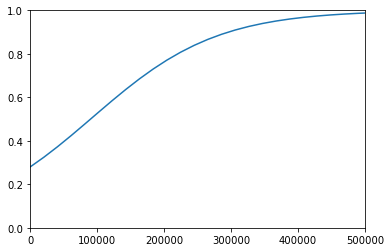

In [29]:
import matplotlib.pyplot as plt
# print("x = 2 at P = %.0f" % (2/a+b))
# print("x = %.0f" % (a*(sat - b)))
# print(df.loc[3,"Value"]-df.loc[2,"Value"])

x = np.linspace(0,1e6)
y = (A + (1 - A) / (1 + np.exp(-a * (x - b))))

plt.plot(x,y)
plt.axis([0, 5e5, 0, 1])
plt.show()